In [1055]:
#from google.colab import output
#output.clear()

In [1056]:
# ライブラリのインストール（初回のみ）
#!pip install japanize-matplotlib

In [1057]:
# （参考）Google Driveにマウントして、ここからデータを読む場合
#from google.colab import drive
#drive.mount('/content/drive')

In [1058]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas_profiling as pdp
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
import math
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import re
import folium
import warnings
import japanize_matplotlib

warnings.simplefilter('ignore', FutureWarning)
# Set Display Max Columns
pd.set_option("display.max_columns", 50)

# 各種関数

In [1059]:
# 欠損値をplotする
def missing_plot(df):
    cols_has_null = df.isnull().sum().to_frame(name="count").query("count > 0").index
    plt.figure(figsize=(10,4))
    cmap = sns.color_palette("deep", 2)
    ax = sns.heatmap(df[cols_has_null].isnull(), cmap=cmap)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['Not Missing','Missing'])
    plt.title("Missing Values")
    plt.show()
    
#カテゴリーの説明変数の確認とプロット
def category(x,df):

    unit = df.groupby([x]).PRICE.mean()
    display(unit)

    unit_count = df.groupby([x]).PRICE.count()
    display(unit_count)

    unit.plot(kind="bar")
    plt.show()

#正規分布の確認
def check_norm(x):
    plt.hist(x, bins=100)#ヒストグラム表示
    plt.pause(.01)
    stats.probplot(x, dist="norm", plot=plt)#QQプロット表示
    plt.pause(.01)
    p=stats.shapiro(x)#シャピロウィルク検定
    print(p)

def null_check(x,df):
    print("【"+str(x)+"】"+"Train欠損値数:" + str(df[x].isnull().sum()))
    print("【"+str(x)+"】"+"Test欠損値数:" + str(df[x].isnull().sum()))
    

#データ統計量の確認
def get_cat_num_features(df):
    
    num_features = []
    cat_features = []
    
    for col in df.columns:
        if df[col].dtype == "float64":
            num_features.append(col)
        if df[col].dtype == "int64":
            num_features.append(col)
            
        if df[col].dtype == "object":
            cat_features.append(col)
            
    return num_features, cat_features


def get_unique_df(features):
    unique_df = pd.DataFrame(columns=['Feature', 'Unique', 'Count'])
    for col in features.columns:
        v = features[col].unique()
        l = len(v)
        unique_df = unique_df.append({'Feature':col, 
                                     'Unique':v,
                                     'Count':l}, ignore_index=True)
    return unique_df


def get_null_df(features):
    col_null_df = pd.DataFrame(columns = ['Column', 'Type', 'Total NaN', '%'])
    col_null = features.columns[features.isna().any()].to_list()
    L = len(features)
    for col in col_null:
        T = 0
        if features[col].dtype == "float64":
            T = "Numerical"  
        elif features[col].dtype == "int64":
            T = "Numerical"  
        else:
            T = "Categorical"
        nulls = len(features[features[col].isna() == True][col])   
        col_null_df = col_null_df.append({'Column': col, 
                                          'Type': T,
                                          'Total NaN': nulls,
                                          '%': (nulls / L)*100
                                         }, ignore_index=True)
        
    return col_null_df

def summary(data):
    
    print("Samples --> ", len(data))
    print()
    target = data['PRICE']
    features = data.drop(['PRICE'], axis=1)
    print("Features --> ", len(features.columns))
    print("\n",features.columns)
    
    num_features, cat_features = get_cat_num_features(features)
      
    print()
    print("\nNumerical Features --> ", len(num_features))
    print()
    print(num_features)
    print()
    print("Categorical Features -->", len(cat_features))
    print()
    print(cat_features)
    print()
    print("*************************************************")
    stats = features.describe().T
    
    print()
    print("Value counts of each categorical feature\n")
    for col in cat_features:
        print(col)
        print(features[col].value_counts())
        print()
        
    unique_df = get_unique_df(features)
    
    col_null_df = get_null_df(features)
    
    return {'features':features, 
            'target': target, 
            'stats': stats, 
            'unique_df':unique_df,
            'col_null_df': col_null_df}

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs, y_pred])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title('Observed-Predicted Plot', fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

def dist_tt(x):
    g=sns.FacetGrid(df_all,hue="D_TYPE",height=5)
    g.map(sns.distplot,x)
    #g.set(xlim=(0,xlim),ylim=(0,ylim))
    g.add_legend()

def hist_tt(x):
    sns.histplot(train_df_all[x])
    sns.histplot(test_df_all[x])


# データの前処理

## データ読み込み

上記より価格との相関が強く見られたBATHRM/HF_BATHRM/ROOMS/BEDROOMS/AYB/GBA/KITCHEN/QUADRANT/CNDTN/SALEDATEでモデルを作成

In [1060]:
#train_df = pd.read_csv("train_set.csv", sep=",", header=0, quotechar="\"")
#test_df = pd.read_csv("test_set.csv", sep=",", header=0, quotechar="\"")
train_df_all = pd.read_csv("./data/DC_train.csv", sep=",", header=0, quotechar="\"")
test_df_all = pd.read_csv("./data/DC_test.csv", sep=",", header=0, quotechar="\"")

train = train_df_all.copy()
test=test_df_all.copy()
train["D_TYPE"] = "Train"
test["D_TYPE"] = "Test"
df_all = pd.concat([train,test],axis=0)
df_all = df_all[df_all["SOURCE"] == "Residential"]

In [1061]:
train_df_all = train_df_all.copy()
test_df_all = test_df_all.copy()

In [1062]:
train_df_all = train_df_all[train_df_all["SOURCE"] == "Residential"]
test_df_all = test_df_all[test_df_all["SOURCE"] == "Residential"]

train_df_all.drop(columns="SOURCE",inplace=True)
test_df_all.drop(columns="SOURCE",inplace=True)

In [1063]:
#train_df_all = train_df[['BATHRM', "HF_BATHRM",'AC','ROOMS', 'BEDRM','AYB','EYB','GBA','SOURCE','QUADRANT','CNDTN','PRICE','SALEDATE']].reset_index(drop=True)
#test_df_all = test_df[["Id",'BATHRM', "HF_BATHRM",'AC','ROOMS', 'BEDRM','AYB','EYB','GBA','SOURCE','QUADRANT','CNDTN','SALEDATE']]
#train_df_all=train_df_all.fillna(np.nan)
#test_df_all=test_df_all.fillna(np.nan)

In [1064]:
df_all_summary = summary(train_df_all)

Samples -->  49440

Features -->  47

 Index(['Id', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED',
       'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'GIS_LAST_MOD_DTTM', 'CMPLX_NUM', 'LIVING_GBA',
       'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT'],
      dtype='object')


Numerical Features -->  25

['Id', 'BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'CMPLX_NUM', 'LIVING_GBA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'CENSUS_TRACT', 'X', 'Y']

Categorical Features --> 22

['HEAT', 'AC', 'SALEDATE', 'Q

In [1065]:
df_all_summary['unique_df'][df_all_summary['unique_df']['Count'] == 1]

,Feature,Unique,Count
28,GIS_LAST_MOD_DTTM,[2018-07-22 18:01:43],1
29,CMPLX_NUM,[nan],1
30,LIVING_GBA,[nan],1


In [1066]:
df_all_summary['col_null_df']

,Column,Type,Total NaN,%
0,AYB,Numerical,82,0.165858
1,YR_RMDL,Numerical,21159,42.797330
2,STORIES,Numerical,16,0.032362
3,CMPLX_NUM,Numerical,49440,100.000000
4,LIVING_GBA,Numerical,49440,100.000000
5,FULLADDRESS,Categorical,252,0.509709
6,CITY,Categorical,249,0.503641
7,STATE,Categorical,249,0.503641
8,NATIONALGRID,Categorical,249,0.503641
9,ASSESSMENT_SUBNBHD,Categorical,7016,14.190939


## ASSESSMENT_SUBNBHD

ASSESSMENT_NBHD
16th Street Heights             5.063678e+05
American University             7.222952e+05
Anacostia                       2.044760e+05
Barry Farms                     2.268388e+05
Berkley                         1.485510e+06
Brentwood                       2.443494e+05
Brightwood                      3.726067e+05
Brookland                       4.123866e+05
Burleith                        8.614896e+05
Capitol Hill                    7.247891e+05
Central-tri 1                   1.189150e+06
Chevy Chase                     7.868241e+05
Chillum                         3.328069e+05
Cleveland Park                  1.292551e+06
Colonial Village                6.929829e+05
Columbia Heights                4.358536e+05
Congress Heights                1.929080e+05
Crestwood                       7.063492e+05
Deanwood                        1.948426e+05
Eckington                       4.204426e+05
Foggy Bottom                    6.409501e+05
Forest Hills                    1.26231

ASSESSMENT_NBHD
16th Street Heights              895
American University             1099
Anacostia                        725
Barry Farms                      164
Berkley                          371
Brentwood                        357
Brightwood                      1576
Brookland                       2177
Burleith                         388
Capitol Hill                    1539
Central-tri 1                     97
Chevy Chase                     2342
Chillum                          360
Cleveland Park                   491
Colonial Village                 233
Columbia Heights                2619
Congress Heights                1534
Crestwood                        345
Deanwood                        2544
Eckington                        883
Foggy Bottom                     120
Forest Hills                     374
Fort Dupont Park                1329
Fort Lincoln                     460
Foxhall                          201
Garfield                         236
Georgetown            

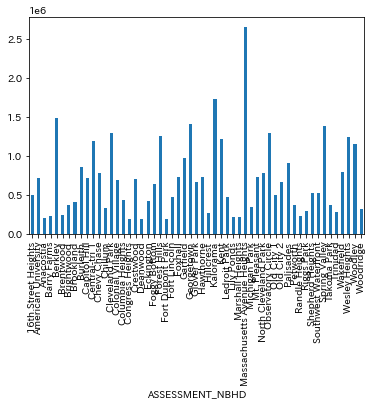

In [1067]:
category("ASSESSMENT_NBHD",train_df_all)

ASSESSMENT_SUBNBHD
001 A American University    679189.097826
001 B American University    693581.177062
001 C American University    775411.014354
002 A Anacostia              191991.120915
002 B Anacostia              213593.899761
                                 ...      
054 B Wesley Heights         740086.834586
056 A Woodridge              348446.066667
056 B Woodridge              311798.857868
056 C Woodridge              307945.438776
056 D Woodridge              299524.352273
Name: PRICE, Length: 121, dtype: float64

ASSESSMENT_SUBNBHD
001 A American University    184
001 B American University    497
001 C American University    418
002 A Anacostia              306
002 B Anacostia              419
                            ... 
054 B Wesley Heights         133
056 A Woodridge              405
056 B Woodridge              197
056 C Woodridge              392
056 D Woodridge               88
Name: PRICE, Length: 121, dtype: int64

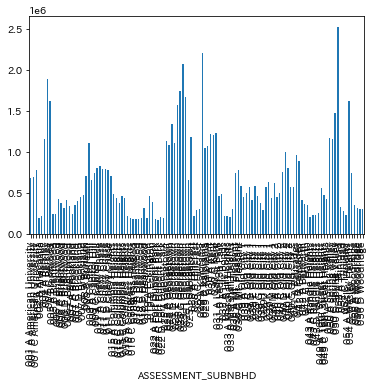

In [1068]:
category("ASSESSMENT_SUBNBHD",train_df_all)

In [1069]:
train_df_all["ASSESSMENT_SUBNBHD"] =train_df_all["ASSESSMENT_SUBNBHD"].fillna("None")

In [1070]:
train_df_all[train_df_all["ASSESSMENT_SUBNBHD"].str.contains("University")]

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE
19,19,2,0,Warm Cool,Y,1.0,8,4,1938.0,NaN,1961,2.0,1992-01-02,Q,1,1388.0,1,2 Story,Single,Very Good,Good,Common Brick,Slate,Hardwood,1.0,1,12,4950,2018-07-22 18:01:43,NaN,NaN,4912 45TH STREET NW,WASHINGTON,DC,20016.0,18S UJ 18992 13732,38.953865,-77.088904,American University,001 B American University,1001.0,001001 5002,Ward 3,1572,-77.089753,38.954024,NW,295000.0
21,21,1,0,Hot Water Rad,Y,1.0,5,2,1936.0,NaN,1960,2.0,1992-01-03,Q,1,1117.0,1,2 Story,Single,Good Quality,Average,Common Brick,Comp Shingle,Hardwood,1.0,1,12,3638,2018-07-22 18:01:43,NaN,NaN,4429 RIVER ROAD NW,WASHINGTON,DC,20016.0,18S UJ 19116 13751,38.954067,-77.087480,American University,001 A American University,1001.0,001001 2003,Ward 3,1583,-77.086967,38.954092,NW,202000.0
41,41,2,1,Warm Cool,Y,1.0,8,3,1939.0,2002.0,1954,2.0,1992-01-13,Q,1,3118.0,1,2 Story,Single,Very Good,Very Good,Brick/Siding,Slate,Hardwood,1.0,1,12,4950,2018-07-22 18:01:43,NaN,NaN,4716 44TH STREET NW,WASHINGTON,DC,20016.0,18S UJ 19194 13486,38.951689,-77.086507,American University,001 B American University,1001.0,001001 2019,Ward 3,1586,-77.087421,38.951580,NW,280000.0
49,49,2,1,Warm Cool,Y,1.0,7,3,1939.0,NaN,1954,2.0,1992-01-17,Q,1,1276.0,1,2 Story,Single,Very Good,Average,Common Brick,Slate,Hardwood,1.0,1,12,4950,2018-07-22 18:01:43,NaN,NaN,4720 44TH STREET NW,WASHINGTON,DC,20016.0,18S UJ 19196 13499,38.951813,-77.086494,American University,001 B American University,1001.0,001001 2019,Ward 3,1586,-77.087421,38.951580,NW,232500.0
89,89,2,0,Warm Cool,Y,1.0,7,3,1934.0,NaN,1954,2.0,1992-02-05,Q,1,1736.0,1,2 Story,Single,Very Good,Good,Common Brick,Slate,Hardwood,1.0,1,12,3850,2018-07-22 18:01:43,NaN,NaN,4413 BRANDYWINE STREET NW,WASHINGTON,DC,20016.0,18S UJ 19149 13287,38.949890,-77.086980,American University,001 B American University,1001.0,001001 2026,Ward 3,1587,-77.087335,38.950525,NW,275000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81858,81858,2,1,Forced Air,Y,1.0,8,3,1938.0,2011.0,1969,2.0,2016-11-28,Q,5,1752.0,1,2 Story,Single,Good Quality,Good,Common Brick,Slate,Hardwood,1.0,2,12,5610,2018-07-22 18:01:43,NaN,NaN,4605 ALTON PLACE NW,WASHINGTON,DC,20016.0,18S UJ 18790 13006,38.947286,-77.091040,American University,001 C American University,1001.0,001001 6001,Ward 3,1550,-77.091593,38.947495,NW,1300000.0
82044,82044,4,1,Warm Cool,Y,1.0,9,4,1945.0,2017.0,1973,2.0,2016-12-05,Q,2,2552.0,1,2 Story,Single,Very Good,Good,Common Brick,Comp Shingle,Hardwood,2.0,2,12,5308,2018-07-22 18:01:43,NaN,NaN,4319 MURDOCK MILL ROAD NW,WASHINGTON,DC,20016.0,18S UJ 19291 13110,38.948327,-77.085299,American University,001 B American University,1001.0,001001 2027,Ward 3,1647,-77.085234,38.948803,NW,1140000.0
82275,82275,2,1,Warm Cool,Y,1.0,7,3,1926.0,1968.0,1969,2.0,2016-12-13,Q,2,1216.0,1,2 Story,Semi-Detached,Good Quality,Good,Common Brick,Metal- Sms,Hardwood,1.0,0,13,1544,2018-07-22 18:01:43,NaN,NaN,4400 CHESAPEAKE STREET NW,WASHINGTON,DC,20016.0,18S UJ 19202 13392,38.950846,-77.086400,American University,001 B American University,1001.0,001001 2018,Ward 3,1587,-77.087335,38.950525,NW,750000.0
82430,82430,1,1,Forced Air,Y,1.0,7,3,1929.0,NaN,1969,2.0,2016-12-20,Q,2,1200.0,1,2 Story,Single,Good Quality,Good,Wood Siding,Comp Shingle,Hardwood,1.0,0,12,4500,2018-07-22 18:01:43,NaN,NaN,4311 ELLICOTT STREET NW,WASHINGTON,DC,20016.0,18S UJ 19389 13681,38.953488,-77.084316,American University,001 A American University,1001.0,001001 2001,Ward 3,1654,-77.085186,38.953968,NW,807500

## BLDG_NUM

BLDG_NUM
1    5.422971e+05
2    2.962364e+06
Name: PRICE, dtype: float64

BLDG_NUM
1    49429
2       11
Name: PRICE, dtype: int64

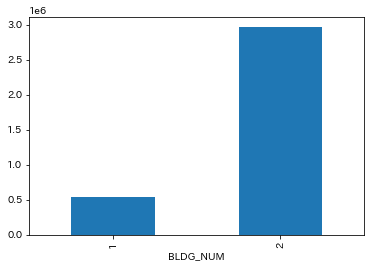

In [1071]:
category("BLDG_NUM",train_df_all)

<AxesSubplot:xlabel='BLDG_NUM', ylabel='Count'>

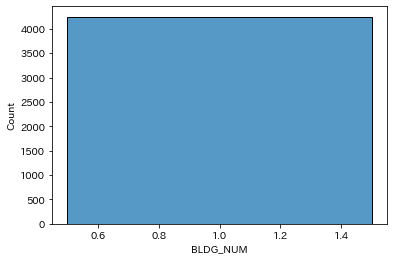

In [1072]:
sns.histplot(test_df_all["BLDG_NUM"])

## ZIPCODE

ZIPCODE
20001.0    4.826328e+05
20002.0    4.446654e+05
20003.0    6.011603e+05
20005.0    7.921188e+05
20007.0    1.156007e+06
20008.0    1.316025e+06
20009.0    7.777945e+05
20010.0    5.174382e+05
20011.0    3.971599e+05
20012.0    4.755049e+05
20015.0    7.805473e+05
20016.0    1.011868e+06
20017.0    4.039856e+05
20018.0    3.594650e+05
20019.0    2.010954e+05
20020.0    2.319885e+05
20024.0    4.653823e+05
20032.0    2.000127e+05
20036.0    1.298641e+06
20037.0    7.596131e+05
20052.0    5.378571e+05
Name: PRICE, dtype: float64

ZIPCODE
20001.0    2734
20002.0    6861
20003.0    3276
20005.0     110
20007.0    3076
20008.0    1650
20009.0    1689
20010.0    2080
20011.0    6386
20012.0    1547
20015.0    2314
20016.0    3172
20017.0    1880
20018.0    2188
20019.0    5069
20020.0    3233
20024.0     291
20032.0    1632
20036.0      72
20037.0     173
20052.0       7
Name: PRICE, dtype: int64

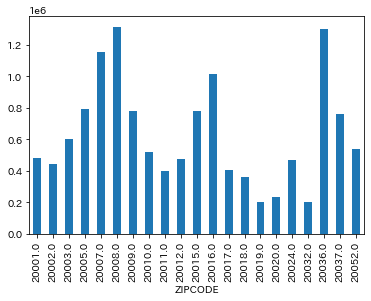

In [1073]:
category("ZIPCODE",train_df_all)

## KITCHEN

KITCHENS
0.0     603180.628571
1.0     517192.206326
2.0     718496.008028
3.0     631857.075646
4.0     436118.382748
5.0     524507.750000
6.0     749166.666667
44.0    315000.000000
Name: PRICE, dtype: float64

KITCHENS
0.0        35
1.0     40688
2.0      6602
3.0       542
4.0      1565
5.0         4
6.0         3
44.0        1
Name: PRICE, dtype: int64

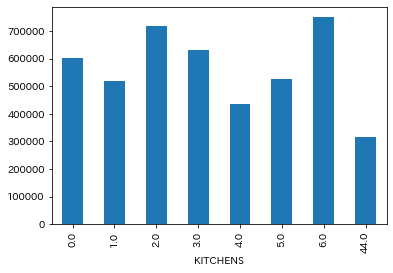

In [1074]:
category("KITCHENS",train_df_all)

## FIREPLACE

FIREPLACES
0     3.565730e+05
1     6.238005e+05
2     8.950271e+05
3     1.324160e+06
4     1.828206e+06
5     2.269777e+06
6     2.735827e+06
7     3.739181e+06
8     3.164688e+06
9     3.323500e+06
10    6.256000e+06
11    3.926500e+06
12    8.600000e+06
13    6.350000e+06
Name: PRICE, dtype: float64

FIREPLACES
0     27199
1     15158
2      5213
3      1218
4       406
5       134
6        69
7        24
8         8
9         4
10        2
11        2
12        1
13        2
Name: PRICE, dtype: int64

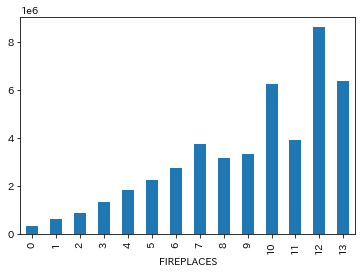

In [1075]:
category("FIREPLACES",train_df_all)

In [1076]:
test_df_all["FIREPLACES"].value_counts()

0    2411
1    1236
2     421
3     104
4      42
5      17
6      14
7       2
Name: FIREPLACES, dtype: int64

In [1077]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["FIREPLACES"]<8]

## BATHRM/HF_BATHRM

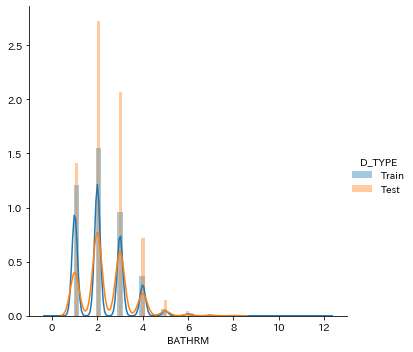

In [1078]:
dist_tt("BATHRM")

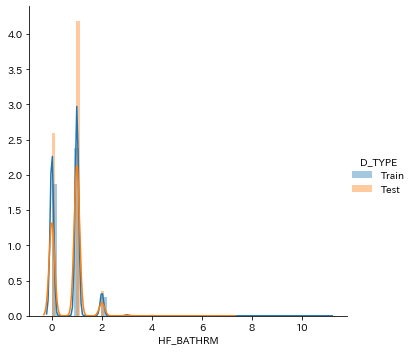

In [1079]:
dist_tt("HF_BATHRM")

In [1080]:
#BATHROOMとHFBATHROOMは合計の値を説明変数にする
train_df_all["BATHRM_ALL"] = train_df_all['BATHRM'] + train_df_all["HF_BATHRM"]
test_df_all["BATHRM_ALL"] = test_df_all['BATHRM'] + test_df_all["HF_BATHRM"]

## ROOMS/BEDROOMS

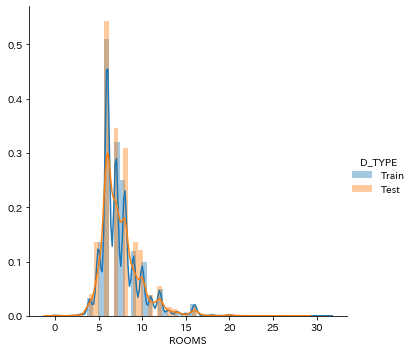

In [1081]:
dist_tt("ROOMS")

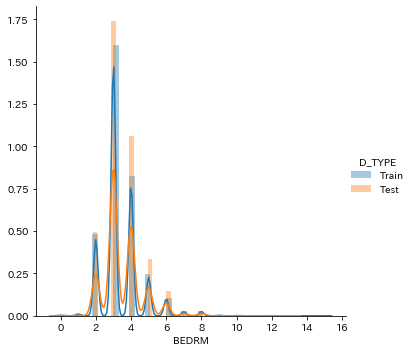

In [1082]:
dist_tt("BEDRM")

In [1083]:
#ROOMの合計はROOMSとBEDRMの合計とする
train_df_all["ROOM_ALL"] = train_df_all['ROOMS'] + train_df_all['BEDRM']
test_df_all["ROOM_ALL"] = test_df_all['ROOMS'] + test_df_all['BEDRM']

## AYB

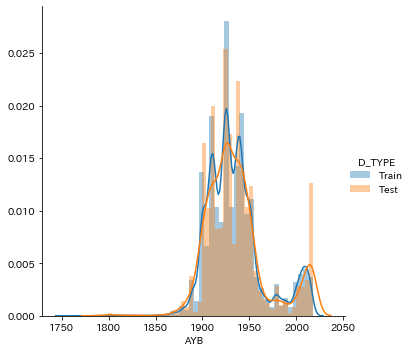

In [1084]:
dist_tt("AYB")

In [1085]:
#AYBの欠損値補完
#ほとんどの場合でAYBとEYBは同じ。AYBの欠損値はEYBで補完
train_df_all["AYB"] = train_df_all["AYB"].fillna(value=train_df_all["EYB"])
test_df_all["AYB"] = test_df_all["AYB"].fillna(value=test_df_all["EYB"])

In [1086]:
train_df_all["AYB"].describe()

count    49421.000000
mean      1934.553975
std         30.481246
min       1765.000000
25%       1913.000000
50%       1929.000000
75%       1947.000000
max       2018.000000
Name: AYB, dtype: float64

In [1087]:
train_df_all['AYB_GROUP']  = train_df_all['AYB'].astype(float)
bins =  [1750] + [i for i in range(1850, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['AYB_GROUP'] = pd.cut(train_df_all['AYB'], bins=bins, labels = labels)

AYB_GROUP
1750-1850    2.023127e+06
1850-1860    1.038870e+06
1860-1870    8.872644e+05
1870-1880    7.515577e+05
1880-1890    7.012610e+05
1890-1900    7.377452e+05
1900-1910    5.460993e+05
1910-1920    5.417850e+05
1920-1930    5.351730e+05
1930-1940    5.099022e+05
1940-1950    3.497074e+05
1950-1960    4.716872e+05
1960-1970    5.570005e+05
1970-1980    5.564248e+05
1980-1990    8.829077e+05
1990-2000    6.684338e+05
2000-2010    4.869931e+05
2010-2020    6.780022e+05
Name: PRICE, dtype: float64

AYB_GROUP
1750-1850     118
1850-1860      39
1860-1870     127
1870-1880     290
1880-1890    1018
1890-1900    3907
1900-1910    5047
1910-1920    5592
1920-1930    9642
1930-1940    7428
1940-1950    6199
1950-1960    3108
1960-1970     991
1970-1980     898
1980-1990     737
1990-2000     675
2000-2010    2166
2010-2020    1439
Name: PRICE, dtype: int64

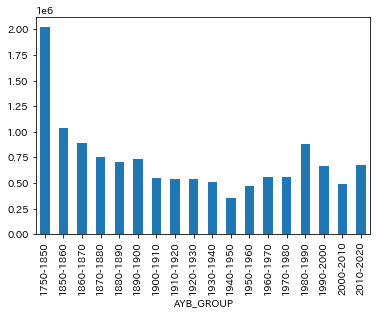

In [1088]:
category("AYB_GROUP",train_df_all)

In [1089]:
test_df_all["AYB"].describe()

count    4247.000000
mean     1935.979515
std        33.261568
min      1790.000000
25%      1913.000000
50%      1929.000000
75%      1948.000000
max      2018.000000
Name: AYB, dtype: float64

In [1090]:
test_df_all['AYB_GROUP']  = test_df_all['AYB'].astype(float)
bins =  [1750] + [i for i in range(1850, 2030, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['AYB_GROUP'] = pd.cut(test_df_all['AYB'], bins=bins, labels = labels)

## YR_RMDL

In [1091]:
train_df_all["YR_RMDL"].describe()

count    28262.000000
mean      2003.736537
std         17.144980
min         20.000000
25%       2002.000000
50%       2007.000000
75%       2012.000000
max       2018.000000
Name: YR_RMDL, dtype: float64

In [1092]:
train_df_all["YR_RMDL"].isnull().sum()

21159

In [1093]:
#SALE_DATEはYEARに変換
train_df_all["SALEDATE"] = pd.to_datetime(train_df_all["SALEDATE"])
train_df_all["SALEDATE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
train_df_all["SALEDATE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

In [1094]:
train_df_all["YR_RMDL_2"]= train_df_all["YR_RMDL"].fillna(value=train_df_all["SALEDATE_YEAR"])

In [1095]:
train_df_all["RM_SALE_1"] = train_df_all["SALEDATE_YEAR"] - train_df_all["AYB"]
train_df_all["RM_SALE_2"] = train_df_all["SALEDATE_YEAR"] - train_df_all["YR_RMDL_2"]
train_df_all["RM_SALE"] = train_df_all["RM_SALE_1"] + train_df_all["RM_SALE_2"]

In [1096]:
train_df_all["RM_SALE"]

0         53.0
1         44.0
2         37.0
3         60.0
5         10.0
         ...  
82641     61.0
82642     14.0
82647     75.0
82648     93.0
82651    143.0
Name: RM_SALE, Length: 49421, dtype: float64

In [1097]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["RM_SALE"] <1000]

<AxesSubplot:xlabel='RM_SALE', ylabel='PRICE'>

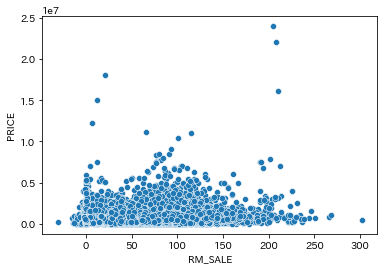

In [1098]:
sns.scatterplot(data=train_df_all,x="RM_SALE",y="PRICE")

In [1099]:
(train_df_all["YR_RMDL"] <1000).sum()

0

In [1100]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["YR_RMDL"] >1000]

In [1101]:
test_df_all["YR_RMDL"].describe()

count    2816.000000
mean     2008.533026
std        11.886481
min      1920.000000
25%      2005.000000
50%      2012.000000
75%      2017.000000
max      2018.000000
Name: YR_RMDL, dtype: float64

In [1102]:
a = train_df_all[["AYB", "AYB_GROUP","YR_RMDL"]]
b = test_df_all[["AYB","AYB_GROUP","YR_RMDL"]]
a = a[~a["YR_RMDL"].isnull()]
b = b[~b["YR_RMDL"].isnull()]

temp_yr = pd.concat([a,b],axis=0)

In [1103]:
temp_yr["duration"] = temp_yr["YR_RMDL"] - temp_yr["AYB"]
temp_yr["duration"].describe()

count    31077.000000
mean        80.123789
std         24.260063
min        -31.000000
25%         66.000000
50%         82.000000
75%         97.000000
max        234.000000
Name: duration, dtype: float64

In [1104]:
temp_yr=temp_yr[temp_yr["duration"] > 0]

In [1105]:
fill_rmyr = temp_yr.groupby("AYB_GROUP").duration.mean().reset_index()
fill_rmyr.index = fill_rmyr["AYB_GROUP"]

In [1106]:
fill_rmyr["duration"] = fill_rmyr["duration"].fillna(0)
ym_ave = fill_rmyr.to_dict(orient="dict")["duration"]

In [1107]:
ym_ave

{'1750-1850': 175.2578125,
 '1850-1860': 141.05,
 '1860-1870': 132.376,
 '1870-1880': 120.75179856115108,
 '1880-1890': 111.56223628691983,
 '1890-1900': 101.60046056419114,
 '1900-1910': 96.0398810998266,
 '1910-1920': 90.17917731815012,
 '1920-1930': 79.76959340011786,
 '1930-1940': 67.72845831392641,
 '1940-1950': 60.93986394557823,
 '1950-1960': 50.97019464720194,
 '1960-1970': 41.12761506276151,
 '1970-1980': 29.03235294117647,
 '1980-1990': 20.840989399293285,
 '1990-2000': 12.435185185185185,
 '2000-2010': 7.9156626506024095,
 '2010-2020': 3.0}

In [1108]:
def fill_YRRMDL(x):
    x=ym_ave[x]
    return x

train_df_all["YRRM_AVE"] = train_df_all["AYB_GROUP"]
test_df_all["YRRM_AVE"] = test_df_all["AYB_GROUP"]
train_df_all["YRRM_AVE"] = train_df_all["YRRM_AVE"].apply(lambda x:fill_YRRMDL(x)).astype(float)
test_df_all["YRRM_AVE"] = test_df_all["YRRM_AVE"].apply(lambda x:fill_YRRMDL(x)).astype(float)

In [1109]:
train_df_all["YRRM_AVE"] = train_df_all["AYB"] + train_df_all["YRRM_AVE"]
test_df_all["YRRM_AVE"]  = test_df_all["AYB"] + test_df_all["YRRM_AVE"]
train_df_all["YR_RMDL"] = train_df_all["YR_RMDL"].fillna(value=train_df_all["YRRM_AVE"])
test_df_all["YR_RMDL"] = test_df_all["YR_RMDL"].fillna(value=test_df_all["YRRM_AVE"])

In [1110]:
train_df_all["YR_RMDL"].isnull().sum()

0

In [1111]:
test_df_all["YR_RMDL"].isnull().sum()

0

In [1112]:
train_df_all["YR_RMDL"].describe()

count    28261.000000
mean      2003.806730
std         12.438071
min       1880.000000
25%       2002.000000
50%       2007.000000
75%       2012.000000
max       2018.000000
Name: YR_RMDL, dtype: float64

In [1113]:
train_df_all['RM_GROUP']  = train_df_all['YR_RMDL'].astype(float)
bins =  [i for i in range(1790, 2040, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['RM_GROUP'] = pd.cut(train_df_all['YR_RMDL'], bins=bins, labels = labels)

RM_GROUP
1790-1800              NaN
1800-1810              NaN
1810-1820              NaN
1820-1830              NaN
1830-1840              NaN
1840-1850              NaN
1850-1860              NaN
1860-1870              NaN
1870-1880    570000.000000
1880-1890              NaN
1890-1900    415000.000000
1900-1910              NaN
1910-1920    286000.000000
1920-1930    393486.071429
1930-1940    431896.850000
1940-1950    329013.142857
1950-1960    481861.687225
1960-1970    514649.018762
1970-1980    456383.239709
1980-1990    586321.182173
1990-2000    658523.223057
2000-2010    665585.826678
2010-2020    671890.421253
2020-2030              NaN
Name: PRICE, dtype: float64

RM_GROUP
1790-1800        0
1800-1810        0
1810-1820        0
1820-1830        0
1830-1840        0
1840-1850        0
1850-1860        0
1860-1870        0
1870-1880        1
1880-1890        0
1890-1900        2
1900-1910        0
1910-1920        1
1920-1930       14
1930-1940       20
1940-1950       70
1950-1960      227
1960-1970      533
1970-1980     1239
1980-1990     1795
1990-2000     2264
2000-2010    12647
2010-2020     9448
2020-2030        0
Name: PRICE, dtype: int64

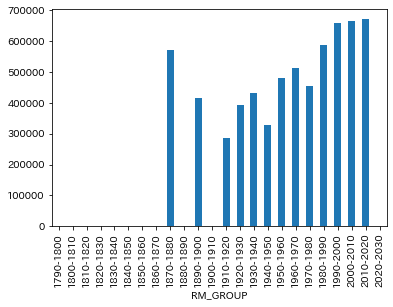

In [1114]:
category("RM_GROUP",train_df_all)

In [1115]:
test_df_all["YR_RMDL"].describe()

count    4247.000000
mean     2008.519847
std        10.328584
min      1920.000000
25%      2004.728458
50%      2010.000000
75%      2016.000000
max      2021.000000
Name: YR_RMDL, dtype: float64

In [1116]:
test_df_all['RM_GROUP']  = test_df_all['YR_RMDL'].astype(float)
bins =  [i for i in range(1790, 2040, 10)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['RM_GROUP'] = pd.cut(test_df_all['YR_RMDL'], bins=bins, labels = labels)

## AC

<AxesSubplot:xlabel='AC', ylabel='Count'>

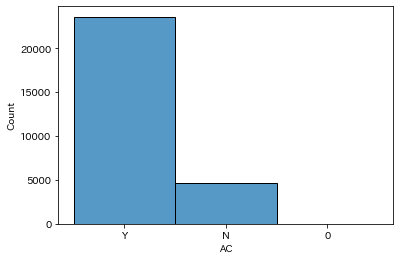

In [1117]:
sns.histplot(train_df_all["AC"])

<AxesSubplot:xlabel='AC', ylabel='Count'>

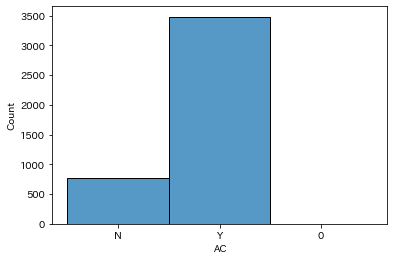

In [1118]:
sns.histplot(test_df_all["AC"])

In [1119]:
#ACのカテゴリー変換
#0はNとして補完
def ac_mod(x):
    if x == 0:
        x="N"
        return x
    elif x == "N":
        x="N"
        return x
    else:
        x="Y"
        return x
    

train_df_all["AC"]=train_df_all["AC"].apply(lambda x: ac_mod(x))
test_df_all["AC"]=test_df_all["AC"].apply(lambda x: ac_mod(x))

## SALEDATE

In [1120]:
#SALE_DATEはYEARに変換
train_df_all["SALEDATE"] = pd.to_datetime(train_df_all["SALEDATE"])
train_df_all["SALEDATE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(str)
train_df_all["SALEDATE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(str)

#bins = np.arange(1900,2040,20)
#labels = ['1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-2020']
#train_df['SALEDATE_YEAR'] = pd.cut(train_df['SALEDATE_YEAR'], bins, labels = labels)

SALEDATE_YEAR
1986     89000.000000
1990    110000.000000
1991    189900.000000
1992    322583.708861
1993    293681.435185
1994    266910.537367
1995    270359.124542
1996    278428.325000
1997    307631.732591
1998    292812.396181
1999    326318.011905
2000    355933.934375
2001    407378.975434
2002    439868.610577
2003    481409.176295
2004    543933.845570
2005    661264.096800
2006    663444.646520
2007    723733.462661
2008    690866.809237
2009    618290.108859
2010    636845.492392
2011    645556.261434
2012    683638.600904
2013    749190.664924
2014    776863.664062
2015    816339.382822
2016    853439.311071
Name: PRICE, dtype: float64

SALEDATE_YEAR
1986       1
1990       1
1991       1
1992     237
1993     216
1994     281
1995     273
1996     320
1997     359
1998     419
1999     504
2000     640
2001     692
2002     832
2003    1004
2004    1185
2005    1250
2006    1092
2007    1165
2008     996
2009    1332
2010    1643
2011    1771
2012    1992
2013    2295
2014    2432
2015    2573
2016    2755
Name: PRICE, dtype: int64

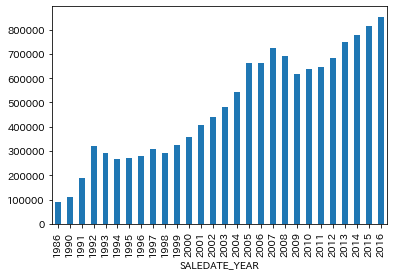

In [1121]:
category("SALEDATE_YEAR",train_df_all)

In [1122]:
train_df_all['SALEDATE_YEAR']  = train_df_all['SALEDATE_YEAR'].astype(float)
bins =  [1980] + [1995] + [i for i in range(2000, 2025, 5)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

train_df_all['SALEDATE_YEAR'] = pd.cut(train_df_all['SALEDATE_YEAR'], bins=bins, labels = labels)

SALEDATE_YEAR
1980-1995    286224.090099
1995-2000    318682.982159
2000-2005    524350.891799
2005-2010    662433.196692
2010-2015    742497.918377
2015-2020    853439.311071
Name: PRICE, dtype: float64

SALEDATE_YEAR
1980-1995     1010
1995-2000     2242
2000-2005     4963
2005-2010     6228
2010-2015    11063
2015-2020     2755
Name: PRICE, dtype: int64

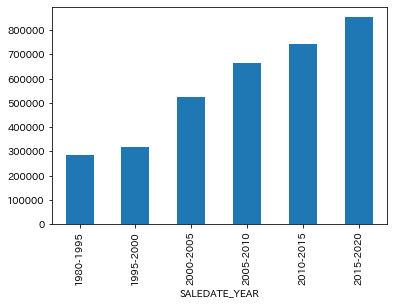

In [1123]:
category("SALEDATE_YEAR",train_df_all)

In [1124]:
#SALE_DATEはYEARに変換
test_df_all["SALEDATE"] = pd.to_datetime(test_df_all["SALEDATE"])
test_df_all["SALEDATE_YEAR"] =test_df_all["SALEDATE"].apply(lambda x : x.year).astype(str)
test_df_all["SALEDATE_MONTH"] =test_df_all["SALEDATE"].apply(lambda x : x.month).astype(str)

#bins = np.arange(1900,2040,20)
#labels = ['1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000-2020']
#train_df['SALEDATE_YEAR'] = pd.cut(train_df['SALEDATE_YEAR'], bins, labels = labels)

In [1125]:
test_df_all['SALEDATE_YEAR']  = test_df_all['SALEDATE_YEAR'].astype(float)
bins =  [1980] + [1995] + [i for i in range(2000, 2025, 5)]

labels = []
length = len(bins)-1
for i in range(length):
  label = str(bins[i]) + "-" + str(bins[i+1])
  labels.append(label)

test_df_all['SALEDATE_YEAR'] = pd.cut(test_df_all['SALEDATE_YEAR'], bins=bins, labels = labels)

## QUADRANT

QUADRANT
NE    436208.658007
NW    842584.134895
SE    426145.239497
SW    330227.000000
Name: PRICE, dtype: float64

QUADRANT
NE     8237
NW    14856
SE     4927
SW      194
Name: PRICE, dtype: int64

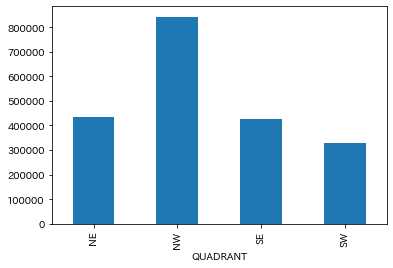

In [1126]:
#QUADRANT 欠損値補完
#QUADRANT NAはここでは最頻値で補完。後ほどLocationの情報をもとに補完。
category("QUADRANT",train_df_all)

In [1127]:
train_df_all["QUADRANT"].mode()[0]

'NW'

In [1128]:
train_df_all["QUADRANT"] = train_df_all["QUADRANT"].replace(np.nan,str(train_df_all["QUADRANT"].mode()[0]))
test_df_all["QUADRANT"] = test_df_all["QUADRANT"].replace(np.nan,str(test_df_all["QUADRANT"].mode()[0]))

In [1129]:
train_df_all["QUADRANT"].unique()

array(['SE', 'NW', 'NE', 'SW'], dtype=object)

## CNDTN

<AxesSubplot:xlabel='CNDTN', ylabel='Count'>

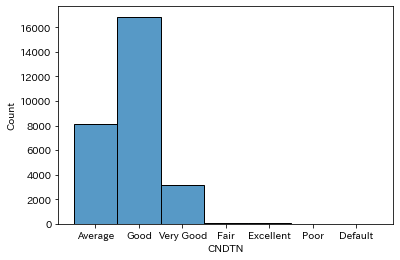

In [1130]:
sns.histplot(train_df_all["CNDTN"])

<AxesSubplot:xlabel='CNDTN', ylabel='Count'>

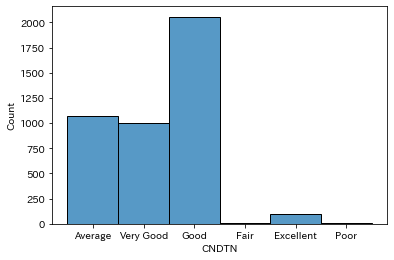

In [1131]:
sns.histplot(test_df_all["CNDTN"])

CNDTN
Average      4.248646e+05
Default      5.175000e+06
Excellent    3.334968e+06
Fair         4.416790e+05
Good         6.625159e+05
Poor         1.570909e+05
Very Good    1.085957e+06
Name: PRICE, dtype: float64

CNDTN
Average       8105
Default          1
Excellent       71
Fair            74
Good         16864
Poor            11
Very Good     3135
Name: PRICE, dtype: int64

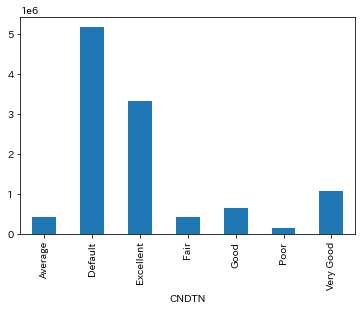

In [1132]:
#CNDTNの欠損値補完
category("CNDTN",train_df_all)

In [1133]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["CNDTN"]!="Default"]

In [1134]:
train_df_all.groupby("CNDTN").AYB.apply(lambda x:x.mean())

CNDTN
Average      1924.960025
Excellent    1923.929577
Fair         1922.878378
Good         1923.980906
Poor         1922.181818
Very Good    1921.708134
Name: AYB, dtype: float64

In [1135]:
def cnd_label(x):
  if x == "Excellent":
    x= 6
    return x
  elif x=="Very Good":
    x= 5
    return x
  elif x == "Good":
    x=4
    return x
  elif x == "Fair":
    x=3
    return x
  elif x == "Average":
    x=2
    return x
  elif x == "Fair":
    x=1
    return x
  elif x == "Poor":
    x=0
    return x

In [1136]:
train_df_all["CNDTN"] = train_df_all["CNDTN"].apply(lambda x : cnd_label(x))
test_df_all["CNDTN"] = test_df_all["CNDTN"].apply(lambda x : cnd_label(x))

CNDTN
0    1.570909e+05
2    4.248646e+05
3    4.416790e+05
4    6.625159e+05
5    1.085957e+06
6    3.334968e+06
Name: PRICE, dtype: float64

CNDTN
0       11
2     8105
3       74
4    16864
5     3135
6       71
Name: PRICE, dtype: int64

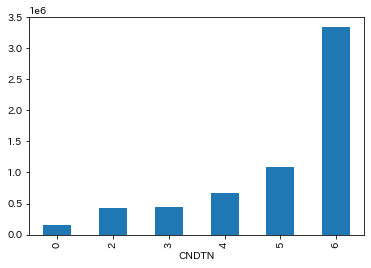

In [1137]:
category("CNDTN",train_df_all)

In [1138]:
train_df_all["CNDTN"].isnull().sum()

0

## LOCATION

In [1139]:
#loc_df = pd.read_csv("./data/raw_address_points.csv", sep=",", header=0, quotechar="\"")
#loc_df.head()

<AxesSubplot:xlabel='LATITUDE', ylabel='LONGITUDE'>

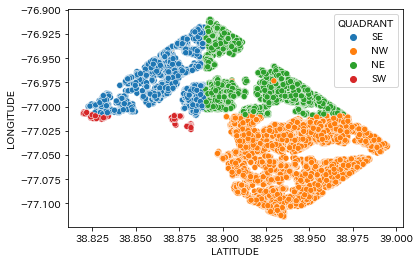

In [1140]:
sns.scatterplot(data = train_df_all, x=train_df_all["LATITUDE"] ,y=train_df_all["LONGITUDE"], hue="QUADRANT")

In [1141]:
#train_df_all = train_df_all.copy()
#temp_df = train_df_all[train_df_all["PRICE"] < 1000000]
temp_df = train_df_all.copy()

In [1142]:
temp_df["LATITUDE"].describe()

count    28260.000000
mean        38.917326
std          0.031035
min         38.819731
25%         38.895027
50%         38.915132
75%         38.939627
max         38.994894
Name: LATITUDE, dtype: float64

In [1143]:
temp_df["LATITUDE"]  = temp_df["LATITUDE"].astype(float)
bins =  np.arange(38.80, 39.00, 0.005)

labels = []
length = len(bins)-1
for i in range(length):
  label = str(round((bins[i] + bins[i+1])/2,4))
  labels.append(label)

temp_df["LATITUDE_GROUP"] = pd.cut(temp_df["LATITUDE"], bins=bins, labels = labels)

In [1144]:
temp_df["LATITUDE_GROUP"] = temp_df["LATITUDE_GROUP"].replace(np.nan,0)

In [1145]:
temp_df["LONGITUDE"].describe()

count    28260.000000
mean       -77.015619
std          0.041446
min        -77.113909
25%        -77.043523
50%        -77.013371
75%        -76.987889
max        -76.909758
Name: LONGITUDE, dtype: float64

In [1146]:
temp_df["LONGITUDE"]  = temp_df["LONGITUDE"].astype(float)
bins =  np.arange(-77.12, -76.89, 0.005)

labels = []
length = len(bins)-1
for i in range(length):
  label = str(round((bins[i] + bins[i+1])/2,4))
  labels.append(label)

temp_df["LONGITUDE_GROUP"] = pd.cut(temp_df["LONGITUDE"], bins=bins, labels = labels)

In [1147]:
temp_df

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,...,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,SALEDATE_YEAR,SALEDATE_MONTH,YR_RMDL_2,RM_SALE_1,RM_SALE_2,RM_SALE,YRRM_AVE,RM_GROUP,LATITUDE_GROUP,LONGITUDE_GROUP
5,5,1,2,Warm Cool,Y,1.0,6,3,1977.0,1985.0,1983,3.0,1986-12-02,Q,1,1870.0,1,3 Story,Row End,Average,2,Shingle,Shake,Hardwood,1.0,...,38.873170,-76.977293,Anacostia,002 B Anacostia,7601.0,007601 1004,Ward 8,5565,-76.976512,38.872954,SE,89000.0,3,9,1970-1980,1980-1995,12,1985.0,9.0,1.0,10.0,2006.032353,1980-1990,38.8725,-76.9775
10,10,2,0,Hot Water Rad,N,2.0,6,4,1911.0,2007.0,1960,2.0,1990-09-29,U,1,1432.0,1,2 Story,Row Inside,Above Average,2,Common Brick,Metal- Sms,Hardwood,2.0,...,38.880525,-76.984268,Old City 1,039 B Old City 1,6900.0,006900 2011,Ward 6,1065,-76.984439,38.879245,SE,110000.0,2,10,1910-1920,1980-1995,9,2007.0,79.0,-17.0,62.0,2001.179177,2000-2010,38.8825,-76.9825
12,12,4,0,Hot Water Rad,N,2.0,8,4,1910.0,1992.0,1960,2.0,1991-03-29,Q,1,1810.0,1,2 Story,Row Inside,Good Quality,2,Common Brick,Metal- Sms,Wood Floor,2.0,...,38.887052,-76.989939,Old City 1,039 M Old City 1,6700.0,006700 2006,Ward 6,1015,-76.989324,38.886668,SE,189900.0,4,12,1900-1910,1980-1995,3,1992.0,81.0,-1.0,80.0,2006.039881,1990-2000,38.8875,-76.9875
22,22,2,1,Forced Air,N,1.0,10,5,1920.0,1988.0,1962,2.5,1992-01-06,Q,1,2715.0,1,2.5 Story Fin,Single,Excellent,2,Stucco,Slate,Hardwood,1.0,...,38.932119,-77.066636,Cleveland Park,None,600.0,000600 3006,Ward 3,2090,-77.067375,38.932049,NW,445000.0,3,15,1910-1920,1980-1995,1,1988.0,72.0,4.0,76.0,2010.179177,1980-1990,38.9325,-77.0675
28,28,1,0,Forced Air,N,1.0,7,3,1942.0,1980.0,1950,2.0,1992-01-07,U,1,1056.0,1,2 Story,Row Inside,Average,2,Common Brick,Built Up,Wood Floor,1.0,...,38.921328,-76.983176,Brentwood,005 A Brentwood,9102.0,009102 3003,Ward 5,4118,-76.982988,38.920450,NE,67500.0,1,10,1940-1950,1980-1995,1,1980.0,50.0,12.0,62.0,2002.939864,1970-1980,38.9225,-76.9825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82639,82639,2,0,Hot Water Rad,Y,1.0,6,3,1928.0,2004.0,1964,2.0,2016-12-30,Q,4,1106.0,1,2 Story,Single,Average,4,Wood Siding,Comp Shingle,Hardwood,1.0,...,38.933912,-76.971257,Woodridge,056 A Woodridge,9400.0,009400 3018,Ward 5,4292,-76.971260,38.933607,NE,535000.0,2,9,1920-1930,2015-2020,12,2004.0,88.0,12.0,100.0,2007.769593,2000-2010,38.9325,-76.9725
82640,82640,1,2,Hot Water Rad,Y,1.0,7,3,1927.0,2011.0,1982,2.0,2016-12-30,Q,3,1508.0,1,2 Story,Row Inside,Good Quality,4,Stone,Metal- Sms,Hardwood,1.0,...,38.928604,-77.040346,Mt. Pleasant,036 B Mt. Pleasant,2702.0,002702 2004,Ward 1,2588,-77.041043,38.928171,NW,937000.0,3,10,1920-1930,2015-2020,12,2011.0,89.0,5.0,94.0,2006.769593,2010-2020,38.9275,-77.0425
82641,82641,2,1,Forced Air,Y,1.0,7,3,1955.0,2016.0,1973,2.0,2016-12-30,Q,3,1346.0,1,2 Story,Semi-Detached,Average,4,Common Brick,Built Up,Carpet,1.0,...,38.955216,-76.991292,Riggs Park,None,9508.0,009508 2004,Ward 5,3752,-76.990900,38.955086,NE,475000.0,3,10,1950-1960,2015-2020,12,2016.0,61.0,0.0,61.0,2005.970195,2010-2020,38.9575,-76.9925
82648,82648,2,1,Forced Air,Y,1.0,8,3,1927.0,2012.0,1964,2.0,2016-12-30,Q,5,1056.0,1,2 Story,Row Inside,Average,5,Common Brick,Metal- Sms,Hardwood,1.0,...,38.952206,-77.022357,Petworth,042 B Petworth,2101.0,002101 3005,Ward 4,3149,-77.022995,38.952523,NW,599900.0,3,11,1920-1930,2015-2020,12,2012.0,89.0,4.0,93.0,2006.769593,2010-2020,38.9525,-77.0225


In [1148]:
temp_df_2 = temp_df.groupby(["LONGITUDE_GROUP","LATITUDE_GROUP"]).PRICE.agg(["mean","count"]).reset_index()
temp_df_2["LONGITUDE_GROUP"] = temp_df_2["LONGITUDE_GROUP"].astype(float)
temp_df_2["LATITUDE_GROUP"] = temp_df_2["LATITUDE_GROUP"].astype(float)
temp_df_fol=temp_df_2.query("count > 20").reset_index(drop=True)


In [1149]:
temp_df_fol

,LONGITUDE_GROUP,LATITUDE_GROUP,mean,count
0,-77.1125,38.9325,8.991040e+05,28
1,-77.1075,38.9275,8.695240e+05,50
2,-77.1075,38.9325,1.197419e+06,56
3,-77.1025,38.9225,8.268542e+05,30
4,-77.1025,38.9275,8.355305e+05,67
...,...,...,...,...
353,-76.9225,38.8975,1.968657e+05,29
354,-76.9225,38.9025,2.014931e+05,31
355,-76.9175,38.8925,2.156636e+05,38
356,-76.9175,38.8975,1.955717e+05,31


In [1150]:

def map_scaling(df):
    
    base_amount = min(df["mean"])

    # 円の大きさの倍率
    scale = 40

    # 地図の定義
    map = folium.Map(location=[38.9, -77], zoom_start=12)

    # 販売量を円の大きさで表す
    for index, row in df.iterrows():
        location = (row["LATITUDE_GROUP"], row["LONGITUDE_GROUP"])   # 座標
        radius = scale * (row["mean"] / base_amount) # 円の大きさ
        # 円を地図に追加
        folium.Circle(location=location,      # 地点の緯度経度
                    radius=radius,          # 円の大きさ
                    color="darkblue",       # 円の色
                    fill_color="darkblue",  # 円内の色
                    popup=row["count"]       # マウスオーバー時の表示項目
        ).add_to(map)
    return map

map_scaling(temp_df_fol)

In [1151]:
temp_df_fol["mean"].sort_values(ascending=False)

80     3.144067e+06
94     2.828894e+06
16     2.481302e+06
78     2.403892e+06
47     2.265688e+06
           ...     
341    1.834555e+05
251    1.825852e+05
346    1.822489e+05
195    1.805609e+05
333    1.774838e+05
Name: mean, Length: 358, dtype: float64

In [1152]:
temp_df_fol

,LONGITUDE_GROUP,LATITUDE_GROUP,mean,count
0,-77.1125,38.9325,8.991040e+05,28
1,-77.1075,38.9275,8.695240e+05,50
2,-77.1075,38.9325,1.197419e+06,56
3,-77.1025,38.9225,8.268542e+05,30
4,-77.1025,38.9275,8.355305e+05,67
...,...,...,...,...
353,-76.9225,38.8975,1.968657e+05,29
354,-76.9225,38.9025,2.014931e+05,31
355,-76.9175,38.8925,2.156636e+05,38
356,-76.9175,38.8975,1.955717e+05,31


In [1153]:
#38.9184°N 77.048°W

In [1154]:
#base_long = -77.048
#base_lat = 38.9184
base_long = temp_df_fol.iloc[80].LONGITUDE_GROUP
base_lat = temp_df_fol.iloc[80].LATITUDE_GROUP

In [1155]:
train_df_all.head()

,Id,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,...,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,PRICE,BATHRM_ALL,ROOM_ALL,AYB_GROUP,SALEDATE_YEAR,SALEDATE_MONTH,YR_RMDL_2,RM_SALE_1,RM_SALE_2,RM_SALE,YRRM_AVE,RM_GROUP
5,5,1,2,Warm Cool,Y,1.0,6,3,1977.0,1985.0,1983,3.0,1986-12-02,Q,1,1870.0,1,3 Story,Row End,Average,2,Shingle,Shake,Hardwood,1.0,...,20020.0,18S UJ 28470 04560,38.873170,-76.977293,Anacostia,002 B Anacostia,7601.0,007601 1004,Ward 8,5565,-76.976512,38.872954,SE,89000.0,3,9,1970-1980,1980-1995,12,1985.0,9.0,1.0,10.0,2006.032353,1980-1990
10,10,2,0,Hot Water Rad,N,2.0,6,4,1911.0,2007.0,1960,2.0,1990-09-29,U,1,1432.0,1,2 Story,Row Inside,Above Average,2,Common Brick,Metal- Sms,Hardwood,2.0,...,20003.0,18S UJ 27883 05390,38.880525,-76.984268,Old City 1,039 B Old City 1,6900.0,006900 2011,Ward 6,1065,-76.984439,38.879245,SE,110000.0,2,10,1910-1920,1980-1995,9,2007.0,79.0,-17.0,62.0,2001.179177,2000-2010
12,12,4,0,Hot Water Rad,N,2.0,8,4,1910.0,1992.0,1960,2.0,1991-03-29,Q,1,1810.0,1,2 Story,Row Inside,Good Quality,2,Common Brick,Metal- Sms,Wood Floor,2.0,...,20003.0,18S UJ 27407 06125,38.887052,-76.989939,Old City 1,039 M Old City 1,6700.0,006700 2006,Ward 6,1015,-76.989324,38.886668,SE,189900.0,4,12,1900-1910,1980-1995,3,1992.0,81.0,-1.0,80.0,2006.039881,1990-2000
22,22,2,1,Forced Air,N,1.0,10,5,1920.0,1988.0,1962,2.5,1992-01-06,Q,1,2715.0,1,2.5 Story Fin,Single,Excellent,2,Stucco,Slate,Hardwood,1.0,...,20008.0,18S UJ 20867 11274,38.932119,-77.066636,Cleveland Park,None,600.0,000600 3006,Ward 3,2090,-77.067375,38.932049,NW,445000.0,3,15,1910-1920,1980-1995,1,1988.0,72.0,4.0,76.0,2010.179177,1980-1990
28,28,1,0,Forced Air,N,1.0,7,3,1942.0,1980.0,1950,2.0,1992-01-07,U,1,1056.0,1,2 Story,Row Inside,Average,2,Common Brick,Built Up,Wood Floor,1.0,...,20018.0,18S UJ 28076 09916,38.921328,-76.983176,Brentwood,005 A Brentwood,9102.0,009102 3003,Ward 5,4118,-76.982988,38.920450,NE,67500.0,1,10,1940-1950,1980-1995,1,1980.0,50.0,12.0,62.0,2002.939864,1970-1980


In [1156]:
from geopy.distance import geodesic

def calculate_distance(row):
    base_point=(base_lat,base_long)
    actual_point = (row["LATITUDE"],row["LONGITUDE"])
    dis = geodesic(base_point, actual_point).km
    return dis

train_df_all["DISTANCE"] =train_df_all.apply(calculate_distance,axis=1)
test_df_all["DISTANCE"] =test_df_all.apply(calculate_distance,axis=1)
    

[(0.0, 12000000.0)]

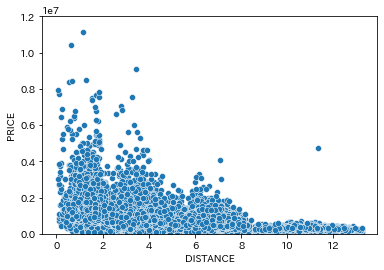

In [1157]:
g=sns.scatterplot(data=train_df_all,x="DISTANCE",y="PRICE")
g.set(ylim=(0,12000000))

## GBA

[(0.0, 12000000.0)]

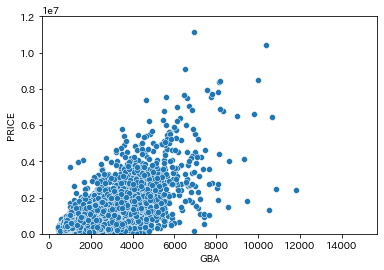

In [1158]:
g=sns.scatterplot(data=train_df_all,x="GBA",y="PRICE")
g.set(ylim=(0,12000000))

## SALE_NUM

SALE_NUM
1     587771.743921
2     934276.843395
3     826790.852122
4     824823.773816
5     796682.571723
6     691963.825996
7     676904.160920
8     581393.974026
9     560535.357143
10    422028.846154
11    517314.285714
12    503166.666667
13    186000.000000
14    480000.000000
15    407000.000000
Name: PRICE, dtype: float64

SALE_NUM
1     21056
2      1143
3      2333
4      1963
5       969
6       477
7       174
8        77
9        42
10       13
11        7
12        3
13        1
14        1
15        1
Name: PRICE, dtype: int64

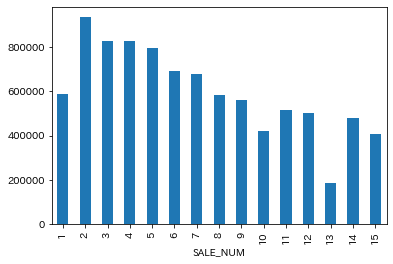

In [1159]:
category("SALE_NUM",train_df_all)

In [1160]:
train_df_all["SALE_YEAR"] =train_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
train_df_all["SALE_MONTH"] =train_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)
test_df_all["SALE_YEAR"] =test_df_all["SALEDATE"].apply(lambda x : x.year).astype(float)
test_df_all["SALE_MONTH"] =test_df_all["SALEDATE"].apply(lambda x : x.month).astype(float)

In [1161]:
#train_df_all["BULD_AGE"] = 2016 - train_df_all["AYB"]
#test_df_all["BULD_AGE"] = 2016 - test_df_all["AYB"]
train_df_all["BULD_AGE"] = train_df_all["SALE_YEAR"] - train_df_all["AYB"]
test_df_all["BULD_AGE"] = train_df_all["SALE_YEAR"] - test_df_all["AYB"]

<AxesSubplot:xlabel='BULD_AGE', ylabel='PRICE'>

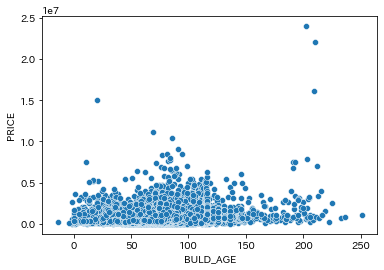

In [1162]:
sns.scatterplot(data=train_df_all,x="BULD_AGE",y="PRICE")

In [1163]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["BULD_AGE"] > 0]
train_df_all["LIV_DUR"] = train_df_all["BULD_AGE"] / train_df_all["SALE_NUM"]

test_df_all = test_df_all.copy()
#test_df_all = test_df_all[test_df_all["LIV_DUR"] > 0]
test_df_all["LIV_DUR"] = test_df_all["BULD_AGE"] / test_df_all["SALE_NUM"]

[(0.0, 12000000.0)]

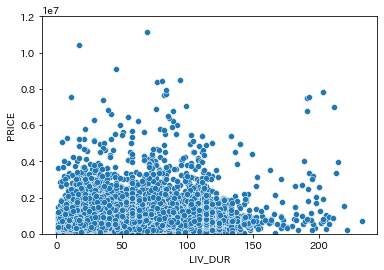

In [1164]:
g=sns.scatterplot(data=train_df_all,x="LIV_DUR",y="PRICE")
g.set(ylim=(0,12000000))

## GRADE

GRADE
Above Average    5.063753e+05
Average          3.530885e+05
Excellent        1.242877e+06
Exceptional-A    2.280392e+06
Exceptional-B    3.365470e+06
Exceptional-C    7.494491e+06
Exceptional-D    5.732590e+06
Fair Quality     2.151064e+05
Good Quality     7.093651e+05
Superior         1.467146e+06
Very Good        9.431222e+05
Name: PRICE, dtype: float64

GRADE
Above Average    8010
Average          8681
Excellent        1086
Exceptional-A     335
Exceptional-B      98
Exceptional-C      25
Exceptional-D      18
Fair Quality       32
Good Quality     6282
Superior          960
Very Good        2703
Name: PRICE, dtype: int64

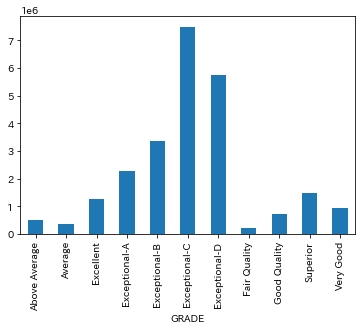

In [1165]:
category("GRADE",train_df_all)

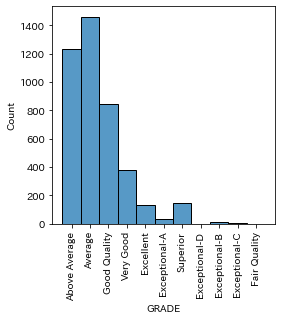

In [1166]:
fig, ax = plt.subplots(figsize = (4,4)) 

sns.histplot(test_df_all["GRADE"])
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

In [1167]:
train_df_all["GRADE"].isnull().sum()

0

In [1168]:
train_df_all["GRADE"].unique()

array(['Average', 'Above Average', 'Good Quality', 'Excellent',
       'Very Good', 'Superior', 'Exceptional-A', 'Exceptional-B',
       'Exceptional-D', 'Exceptional-C', 'Fair Quality'], dtype=object)

In [1169]:
def grade_label(x):
  if x == 'Exceptional-C':
    x= 11
    return x
  elif x=='Exceptional-D':
    x= 10
    return x
  elif x == 'Exceptional-B':
    x=9
    return x
  elif x == 'Exceptional-A':
    x=8
    return x
  elif x == "Superior":
    x=7
    return x
  elif x == "Excellent":
    x= 6
    return x
  elif x=="Very Good":
    x= 5
    return x
  elif x == 'Good Quality':
    x=4
    return x
  elif x == 'Above Average':
    x=3
    return x
  elif x == "Average":
    x=2
    return x
  elif x == 'Fair Quality':
    x=1
    return x
  elif x == 'Low Quality':
    x=0
    return x

In [1170]:
train_df_all["GRADE"] = train_df_all["GRADE"].apply(lambda x : grade_label(x))
test_df_all["GRADE"] = test_df_all["GRADE"].apply(lambda x : grade_label(x))

GRADE
1     2.151064e+05
2     3.530885e+05
3     5.063753e+05
4     7.093651e+05
5     9.431222e+05
6     1.242877e+06
7     1.467146e+06
8     2.280392e+06
9     3.365470e+06
10    5.732590e+06
11    7.494491e+06
Name: PRICE, dtype: float64

GRADE
1       32
2     8681
3     8010
4     6282
5     2703
6     1086
7      960
8      335
9       98
10      18
11      25
Name: PRICE, dtype: int64

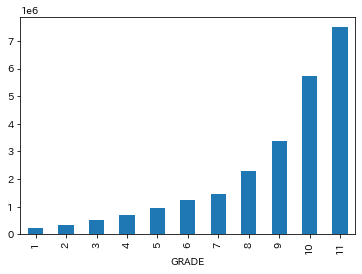

In [1171]:
category("GRADE",train_df_all)

In [1172]:
train_df_all["GRADE"].isnull().sum()

0

## WARD

WARD
Ward 1    6.278632e+05
Ward 2    1.301551e+06
Ward 3    1.102131e+06
Ward 4    5.685780e+05
Ward 5    4.205130e+05
Ward 6    5.931770e+05
Ward 7    2.331946e+05
Ward 8    2.231541e+05
Name: PRICE, dtype: float64

WARD
Ward 1    2633
Ward 2    2249
Ward 3    4217
Ward 4    4764
Ward 5    4056
Ward 6    6228
Ward 7    2822
Ward 8    1261
Name: PRICE, dtype: int64

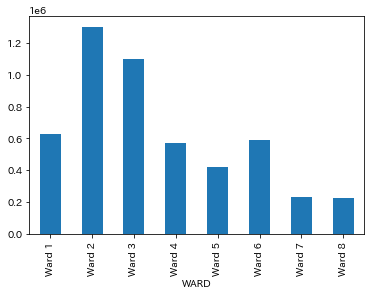

In [1173]:
category("WARD",train_df_all)

## QUALIFIED

QUALIFIED
Q    688971.114953
U    447702.197574
Name: PRICE, dtype: float64

QUALIFIED
Q    23366
U     4864
Name: PRICE, dtype: int64

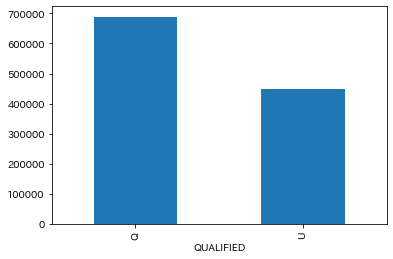

In [1174]:
#CNDTNの欠損値補完
category("QUALIFIED",train_df_all)

<AxesSubplot:xlabel='QUALIFIED', ylabel='Count'>

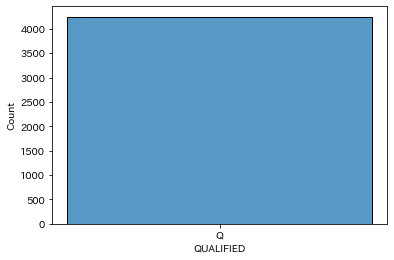

In [1175]:
sns.histplot(test_df_all["QUALIFIED"])

In [1176]:
train_df_all = train_df_all.copy()
train_df_all = train_df_all[train_df_all["QUALIFIED"] == "Q"]

## LAND AREA

In [1177]:
train_df_all.columns

Index(['Id', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED',
       'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'GIS_LAST_MOD_DTTM', 'CMPLX_NUM', 'LIVING_GBA',
       'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'PRICE',
       'BATHRM_ALL', 'ROOM_ALL', 'AYB_GROUP', 'SALEDATE_YEAR',
       'SALEDATE_MONTH', 'YR_RMDL_2', 'RM_SALE_1', 'RM_SALE_2', 'RM_SALE',
       'YRRM_AVE', 'RM_GROUP', 'DISTANCE', 'SALE_YEAR', 'SALE_MONTH',
       'BULD_AGE', 'LIV_DUR'],
      dtype='object')

[(0.0, 12000000.0)]

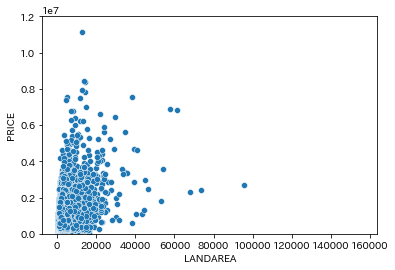

In [1178]:
g=sns.scatterplot(data=train_df_all,x="LANDAREA",y="PRICE")
g.set(ylim=(0,12000000))

## SUMMARY

In [1179]:
test_df_all.columns

Index(['Id', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED',
       'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'GIS_LAST_MOD_DTTM', 'CMPLX_NUM', 'LIVING_GBA',
       'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'BATHRM_ALL',
       'ROOM_ALL', 'AYB_GROUP', 'YRRM_AVE', 'RM_GROUP', 'SALEDATE_YEAR',
       'SALEDATE_MONTH', 'DISTANCE', 'SALE_YEAR', 'SALE_MONTH', 'BULD_AGE',
       'LIV_DUR'],
      dtype='object')

In [1180]:
train_df_all.columns

Index(['Id', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED',
       'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'GIS_LAST_MOD_DTTM', 'CMPLX_NUM', 'LIVING_GBA',
       'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE',
       'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT',
       'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'PRICE',
       'BATHRM_ALL', 'ROOM_ALL', 'AYB_GROUP', 'SALEDATE_YEAR',
       'SALEDATE_MONTH', 'YR_RMDL_2', 'RM_SALE_1', 'RM_SALE_2', 'RM_SALE',
       'YRRM_AVE', 'RM_GROUP', 'DISTANCE', 'SALE_YEAR', 'SALE_MONTH',
       'BULD_AGE', 'LIV_DUR'],
      dtype='object')

In [1181]:
train_df_all = train_df_all[['QUADRANT',"ASSESSMENT_NBHD","FIREPLACES","LIV_DUR",'LANDAREA','SALEDATE_YEAR', 'BATHRM_ALL','ROOM_ALL', 'AYB_GROUP','RM_GROUP', 'GBA','AC', 'CNDTN', 'DISTANCE',"WARD","GRADE",'PRICE']]
test_df_all = test_df_all[['Id',"ASSESSMENT_NBHD",'QUADRANT',"FIREPLACES","LIV_DUR",'LANDAREA','SALEDATE_YEAR' ,'BATHRM_ALL','ROOM_ALL', 'AYB_GROUP','RM_GROUP', 'GBA','AC', 'CNDTN', 'DISTANCE',"WARD","GRADE"]]

In [1182]:
train_df_all.isnull().sum()

QUADRANT           0
ASSESSMENT_NBHD    0
FIREPLACES         0
LIV_DUR            0
LANDAREA           0
SALEDATE_YEAR      0
BATHRM_ALL         0
ROOM_ALL           0
AYB_GROUP          0
RM_GROUP           0
GBA                0
AC                 0
CNDTN              0
DISTANCE           0
WARD               0
GRADE              0
PRICE              0
dtype: int64

In [1183]:
test_df_all.isnull().sum()

Id                    0
ASSESSMENT_NBHD       0
QUADRANT              0
FIREPLACES            0
LIV_DUR            2968
LANDAREA              0
SALEDATE_YEAR         0
BATHRM_ALL            0
ROOM_ALL              0
AYB_GROUP             0
RM_GROUP              0
GBA                   0
AC                    0
CNDTN                 0
DISTANCE              0
WARD                  0
GRADE                 0
dtype: int64

In [1184]:
set(train_df_all.columns)^set(test_df_all.columns)

{'Id', 'PRICE'}

In [1185]:
train_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23366 entries, 5 to 82651
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   QUADRANT         23366 non-null  object  
 1   ASSESSMENT_NBHD  23366 non-null  object  
 2   FIREPLACES       23366 non-null  int64   
 3   LIV_DUR          23366 non-null  float64 
 4   LANDAREA         23366 non-null  int64   
 5   SALEDATE_YEAR    23366 non-null  category
 6   BATHRM_ALL       23366 non-null  int64   
 7   ROOM_ALL         23366 non-null  int64   
 8   AYB_GROUP        23366 non-null  category
 9   RM_GROUP         23366 non-null  category
 10  GBA              23366 non-null  float64 
 11  AC               23366 non-null  object  
 12  CNDTN            23366 non-null  int64   
 13  DISTANCE         23366 non-null  float64 
 14  WARD             23366 non-null  object  
 15  GRADE            23366 non-null  int64   
 16  PRICE            23366 non-null  float64

In [1186]:
train_df_res_dum = pd.get_dummies(data=train_df_all,columns=['AC',"ASSESSMENT_NBHD", 'SALEDATE_YEAR','QUADRANT',"RM_GROUP", 'AYB_GROUP',"WARD"]).reset_index(drop=True)
test_df_res_dum = pd.get_dummies(data=test_df_all,columns=['AC',"ASSESSMENT_NBHD",  'SALEDATE_YEAR','QUADRANT',"RM_GROUP", 'AYB_GROUP',"WARD"])

In [1187]:
#train_df_res_dum = pd.get_dummies(data=train_df_all,columns=['AC', 'QUADRANT',"RM_GROUP", 'AYB_GROUP',"WARD"]).reset_index(drop=True)
#test_df_res_dum = pd.get_dummies(data=test_df_all,columns=['AC','QUADRANT',"RM_GROUP", 'AYB_GROUP',"WARD"])

In [1188]:
set(train_df_res_dum.columns)^set(test_df_res_dum.columns)

{'Id', 'PRICE'}

In [1189]:
train_df_res_dum.to_pickle("./data/train_df_res_dum.pkl")
test_df_res_dum.to_pickle("./data/test_df_res_dum.pkl")